In [1]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import pandas as pd
import numpy as np
import datetime as dt
import re
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

In [2]:
plt.style.use('ggplot') #ggplot스타일 사용
plt.rc('axes', unicode_minus=False)

In [3]:
pt1 = pd.read_csv('plant1_train.csv')
pt2 = pd.read_csv('plant2_train.csv')
pt_test = pd.read_csv('plant_test.csv')

---
# ***Prophet Function***
---
    - 시간이 지날수록 예측력이 떨어짐
    - 24시간 전의 value값도 같이 학습시킬까

In [41]:
# 테스트용
test_data = pt_test
train_data = pt1
train_variable = 'plant1_train.tem_in_loc3'
plant_num = 1
location_num = 3
test_variable = 'plant_test.tem_in'

In [42]:
train_data['date'] = date_convert(train_data,'plant'+ str(plant_num) +'_train.mea_ddhr')
#사전 테스트 데이터셋 구축
test_data_pre_predict = test_data[(test_data['plant_test.loc']==location_num) & (test_data['plant_test.plant']==plant_num)][['plant_test.mea_ddhr',test_variable,'plant_test.x24h_tma','plant_test.x48h_tma']]

test_data_pre_predict['date'] = date_convert(test_data_pre_predict,'plant_test.mea_ddhr')
#예측해야 하는 데이터


In [128]:
def each_variable_prophet_predict(train_data,test_data,plant_num,location_num,train_variable,test_variable):
    
    train_data['date'] = date_convert(train_data,'plant'+ str(plant_num) +'_train.mea_ddhr')
    #사전 테스트 데이터셋 구축
    test_data_pre_predict = test_data[(test_data['plant_test.loc']==location_num) & (test_data['plant_test.plant']==plant_num)][['plant_test.mea_ddhr',test_variable,'plant_test.x24h_tma','plant_test.x48h_tma']]

    test_data_pre_predict['date'] = date_convert(test_data_pre_predict,'plant_test.mea_ddhr')
    #예측해야 하는 데이터
    test_prediction = test_data_pre_predict[['plant_test.x24h_tma','plant_test.x48h_tma']]
    test_prediction['plant_test.x24h_tma_date'] = date_convert(test_prediction,'plant_test.x24h_tma')
    test_prediction['plant_test.x48h_tma_date'] = date_convert(test_prediction,'plant_test.x48h_tma')
    
    ds24 = test_prediction[['plant_test.x24h_tma_date']]
    ds48 = test_prediction[['plant_test.x48h_tma_date']]
    
    ds24.columns = ['ds']
    ds48.columns = ['ds']
    
    
    test_data_pre_predict2 = test_data_pre_predict[['date',test_variable]]
    test_data_pre_predict2.columns = ['ds','y']
    
    df = train_data[['date',train_variable]]
    df.columns = ['ds','y']
    
    df = df.append(test_data_pre_predict2)
    # prophet model 생성
    prp = Prophet()
    
    #Model fitting
    prp.fit(df)
    
    print('fitting success')
    
    #Base 테스트 데이터셋 구축
    test_base = test_data_pre_predict.drop(columns = ['plant_test.mea_ddhr','plant_test.x24h_tma','plant_test.x48h_tma'])
    test_data_pre_predict.drop(columns = ['plant_test.mea_ddhr',test_variable,'plant_test.x24h_tma','plant_test.x48h_tma'],inplace = True)
    
    test_data_pre_predict.columns = ['ds']
    
    train_future_base = prp.make_future_dataframe(periods=365)
    
    forecast_base = prp.predict(train_future_base)
    
    forecast_test = prp.predict(test_data_pre_predict)
    
    #실제 24시간 후, 48시간 후 변수 값에 대한 예측
    forecast24 = prp.predict(ds24)
    forecast48 = prp.predict(ds48)
    
    
    plt.figure(figsize = (15,10))
    plt.plot(forecast_base['ds'],forecast_base['yhat'],label = 'train_predict_value')
    plt.plot(forecast_base['ds'],forecast_base['yhat_upper'], label = 'train_predict_upper')
    plt.plot(forecast_base['ds'],forecast_base['yhat_lower'], label = 'train_predict_lower')
    plt.plot(train_data['date'],train_data[train_variable], label = 'train_real_value')
    plt.plot(test_base['date'],test_base[test_variable], label = 'test_real_value')
    plt.plot(forecast_test['ds'],forecast_test['yhat'], label = 'test_predict_value')
    plt.title(test_variable + ' Prediction Trends')
    
    if 'tem' in train_variable:
        plt.ylim(-50,50)
    elif 'hum' in train_variable:
        plt.ylim(-40,100)

    plt.legend()
    plt.show()
    
    
    pred_value = forecast_test['yhat'].tolist()
    real_value = test_base[test_variable].tolist()
    
    
    rmse = rmse_return(real_value,pred_value)
    
    print('Prophet Predict RMSE : ', rmse)
    
    return forecast_test, forecast_base, rmse, forecast24, forecast48

# ***Prophet을 통한 각 변수 예측***

In [17]:
pt_test.columns

Index(['plant_test.mea_ddhr', 'plant_test.plant', 'plant_test.loc',
       'plant_test.tem_in', 'plant_test.hum_in', 'plant_test.tem_coil',
       'plant_test.tem_out_loc1', 'plant_test.hum_out_loc1',
       'plant_test.x24h_tma', 'plant_test.x24h_cond_loc',
       'plant_test.x48h_tma', 'plant_test.x48h_cond_loc'],
      dtype='object')

In [18]:
pt1.columns

Index(['plant1_train.mea_ddhr', 'plant1_train.tem_in_loc1',
       'plant1_train.hum_in_loc1', 'plant1_train.tem_coil_loc1',
       'plant1_train.tem_in_loc2', 'plant1_train.hum_in_loc2',
       'plant1_train.tem_coil_loc2', 'plant1_train.tem_in_loc3',
       'plant1_train.hum_in_loc3', 'plant1_train.tem_coil_loc3',
       'plant1_train.tem_out_loc1', 'plant1_train.hum_out_loc1',
       'plant1_train.cond_loc1', 'plant1_train.cond_loc2',
       'plant1_train.cond_loc3', 'date'],
      dtype='object')

In [19]:
pt2.columns

Index(['plant2_train.mea_ddhr', 'plant2_train.tem_in_loc1',
       'plant2_train.hum_in_loc1', 'plant2_train.tem_coil_loc1',
       'plant2_train.tem_in_loc2', 'plant2_train.hum_in_loc2',
       'plant2_train.tem_coil_loc2', 'plant2_train.tem_in_loc3',
       'plant2_train.hum_in_loc3', 'plant2_train.tem_coil_loc3',
       'plant2_train.tem_out_loc1', 'plant2_train.hum_out_loc1',
       'plant2_train.cond_loc1', 'plant2_train.cond_loc2',
       'plant2_train.cond_loc3'],
      dtype='object')

#### plant1 / location1

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


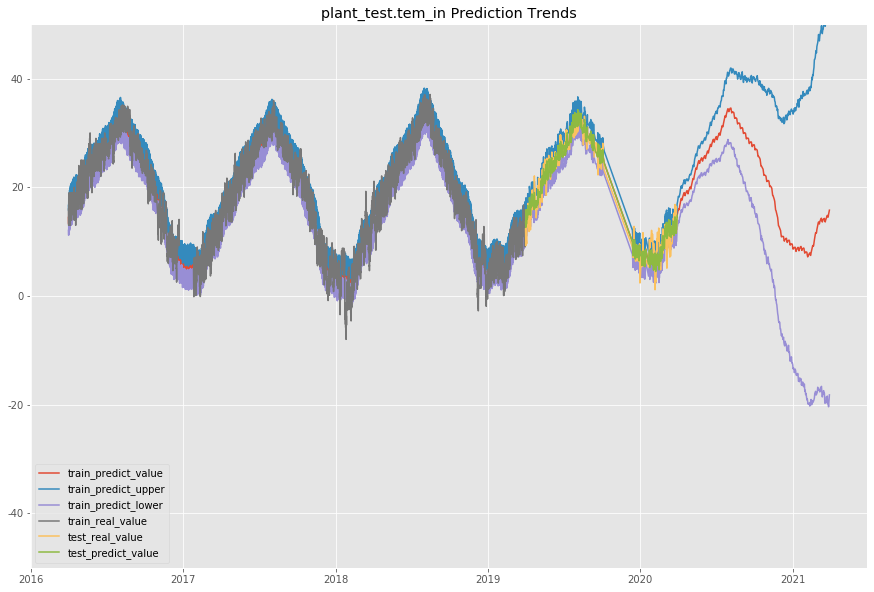

Prophet Predict RMSE :  1.8552124038254758


In [45]:
# plant1, location1, in_tem
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_tem11, forecast48_tem11 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,1,
                                                                                                               'plant1_train.tem_in_loc1',
                                                                                                               'plant_test.tem_in')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


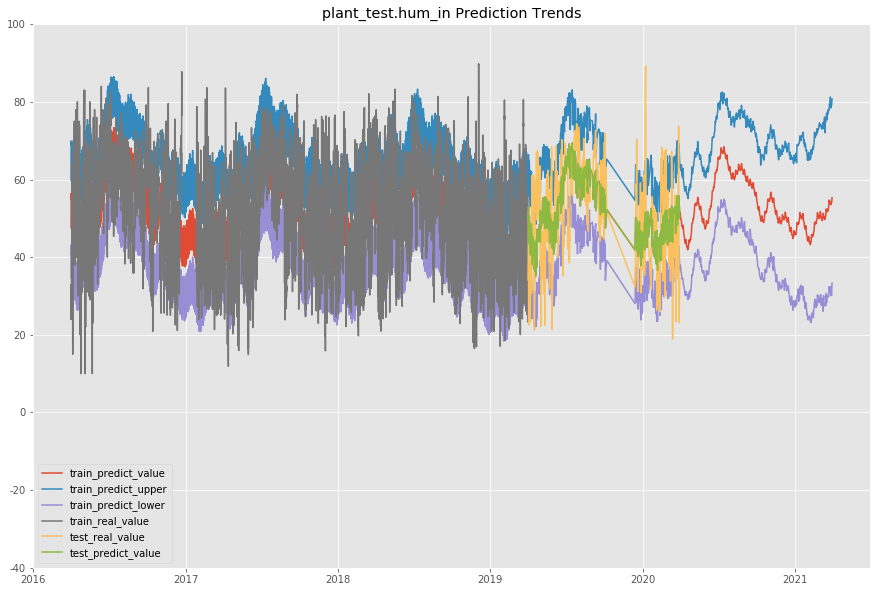

Prophet Predict RMSE :  11.685037406148982


In [129]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_hum11, forecast48_hum11 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,1,
                                                                                                               'plant1_train.hum_in_loc1',
                                                                                                               'plant_test.hum_in')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


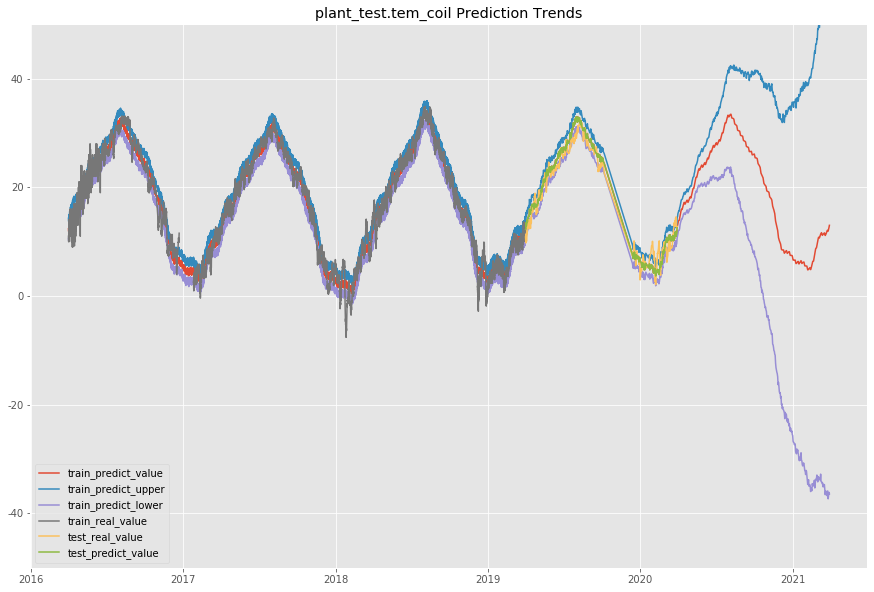

Prophet Predict RMSE :  1.650296706992752


In [47]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_coiltem11, forecast48_coiltem11 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,1,
                                                                                                               'plant1_train.tem_coil_loc1',
                                                                                                               'plant_test.tem_coil')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


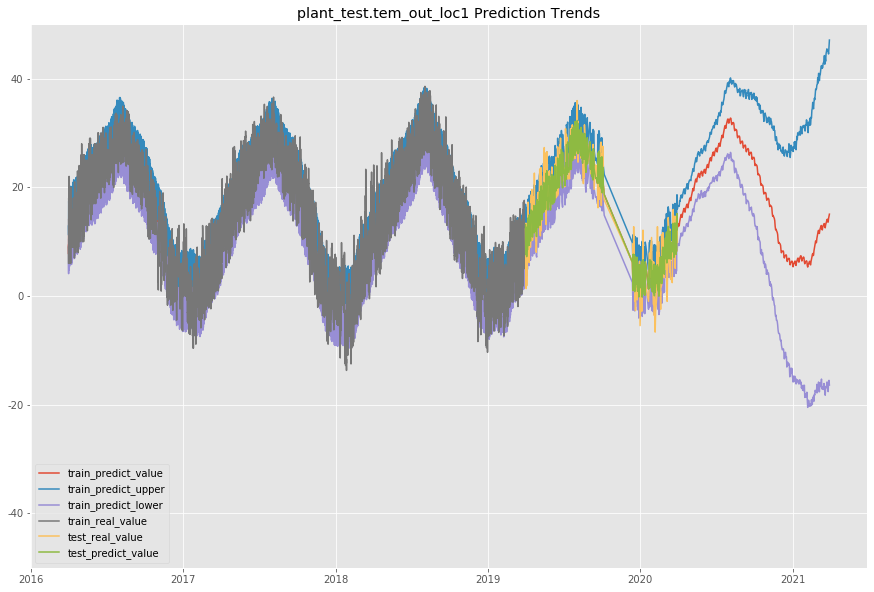

Prophet Predict RMSE :  2.9023594001889785


In [48]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_temout11, forecast48_temout11 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,1,
                                                                                                               'plant1_train.tem_out_loc1',
                                                                                                               'plant_test.tem_out_loc1')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


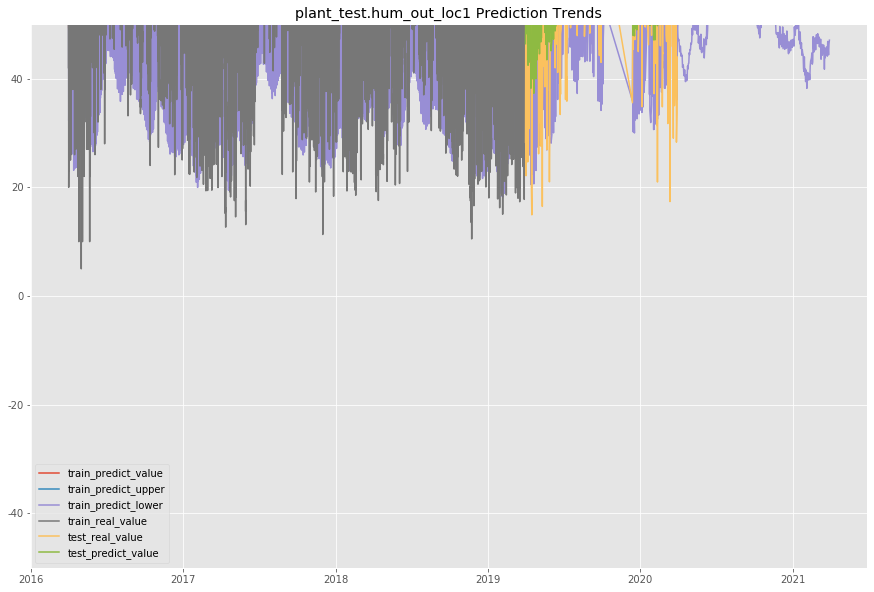

Prophet Predict RMSE :  15.208622659212985


In [49]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_humout11, forecast48_humout11 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,1,
                                                                                                               'plant1_train.hum_out_loc1',
                                                                                                               'plant_test.hum_out_loc1')

#### plant1 / location 2

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


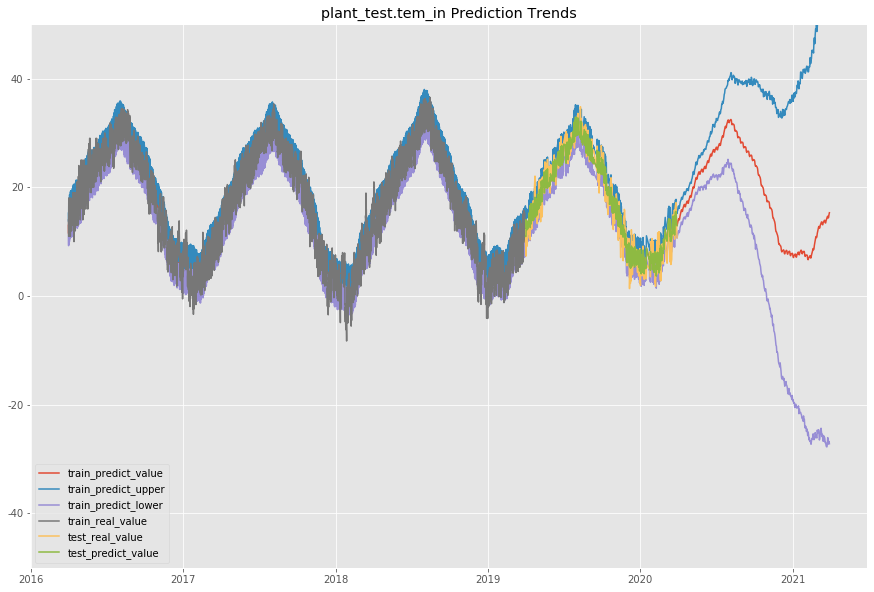

Prophet Predict RMSE :  1.9312085630116393


In [50]:
# plant1, location1, in_tem
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_tem12, forecast48_tem12 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,2,
                                                                                                               'plant1_train.tem_in_loc2',
                                                                                                               'plant_test.tem_in')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


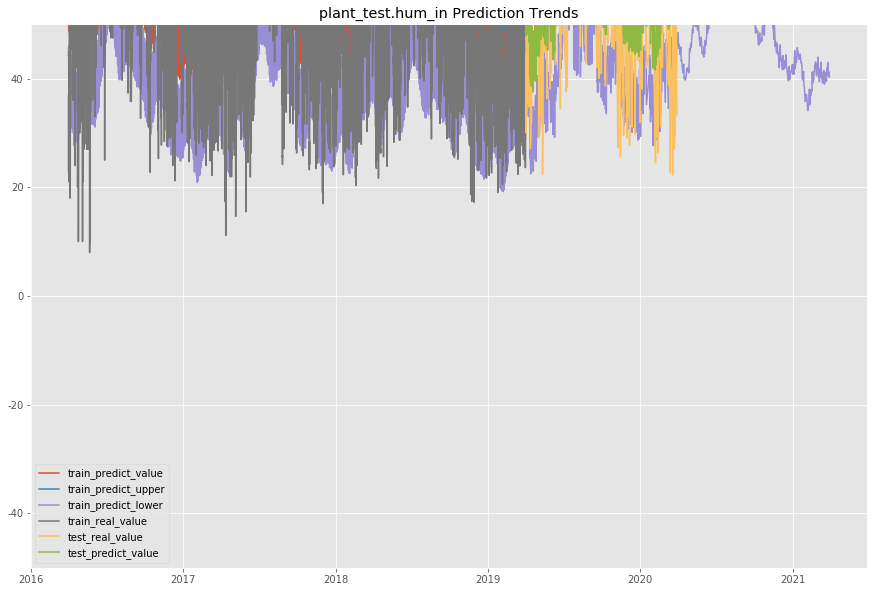

Prophet Predict RMSE :  12.579713304260741


In [51]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_hum12, forecast48_hum12 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,2,
                                                                                                               'plant1_train.hum_in_loc2',
                                                                                                               'plant_test.hum_in')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


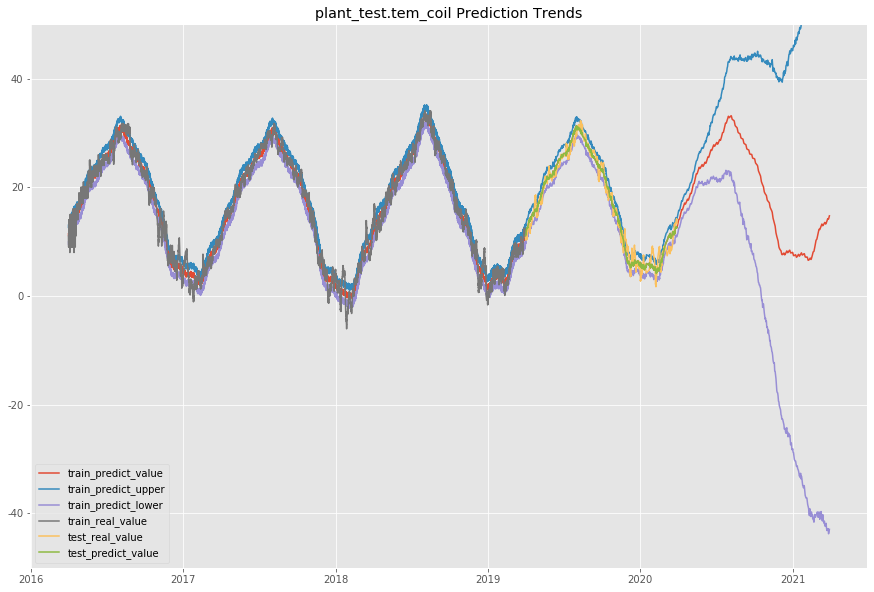

Prophet Predict RMSE :  1.4250307966007547


In [52]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_coiltem12, forecast48_coiltem12 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,2,
                                                                                                               'plant1_train.tem_coil_loc2',
                                                                                                               'plant_test.tem_coil')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


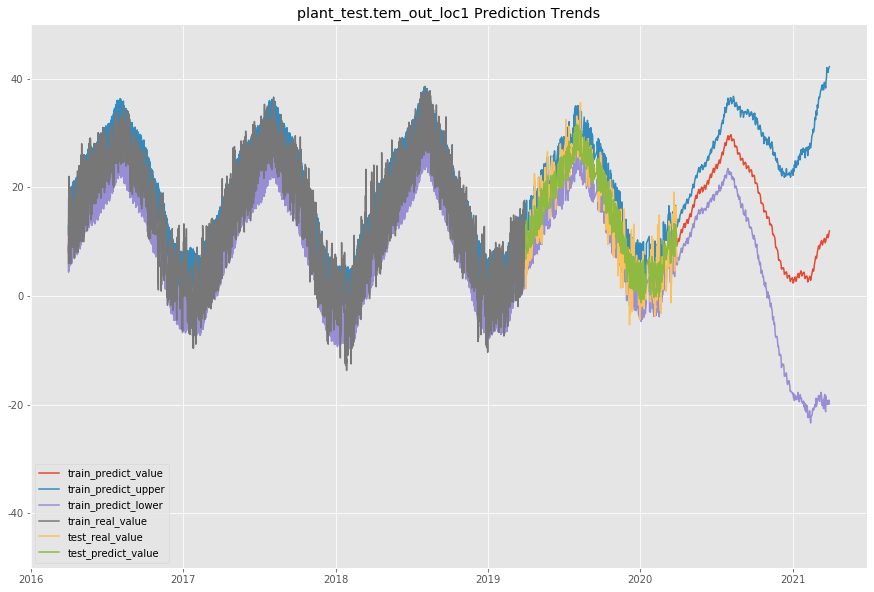

Prophet Predict RMSE :  2.9902238201111793


In [53]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_temout12, forecast48_temout12 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,2,
                                                                                                               'plant1_train.tem_out_loc1',
                                                                                                               'plant_test.tem_out_loc1')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


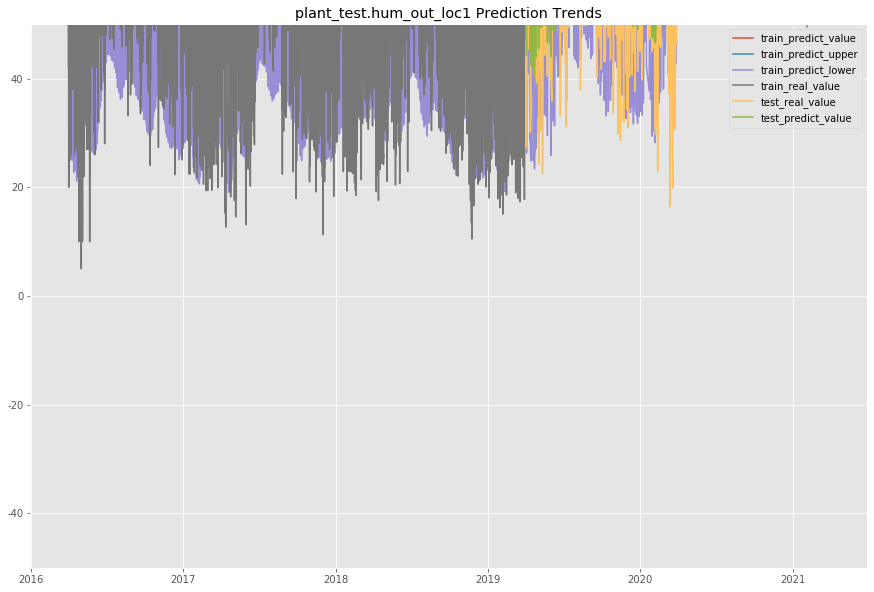

Prophet Predict RMSE :  15.944144810700054


In [54]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_humout12, forecast48_humout12 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,2,
                                                                                                               'plant1_train.hum_out_loc1',
                                                                                                               'plant_test.hum_out_loc1')

#### plant1 / location 3

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


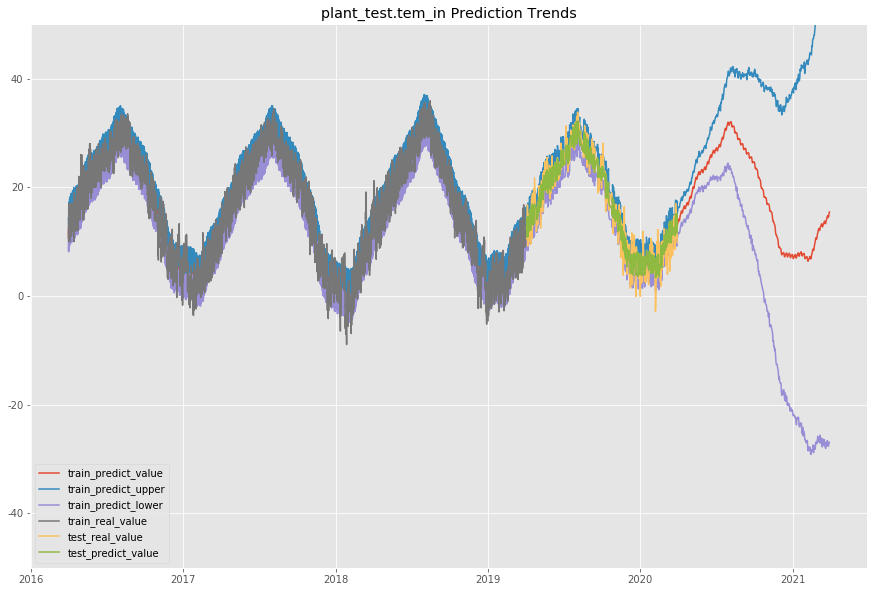

Prophet Predict RMSE :  2.088160178196959


In [55]:
# plant1, location1, in_tem
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_tem13, forecast48_tem13 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,3,
                                                                                                               'plant1_train.tem_in_loc3',
                                                                                                               'plant_test.tem_in')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


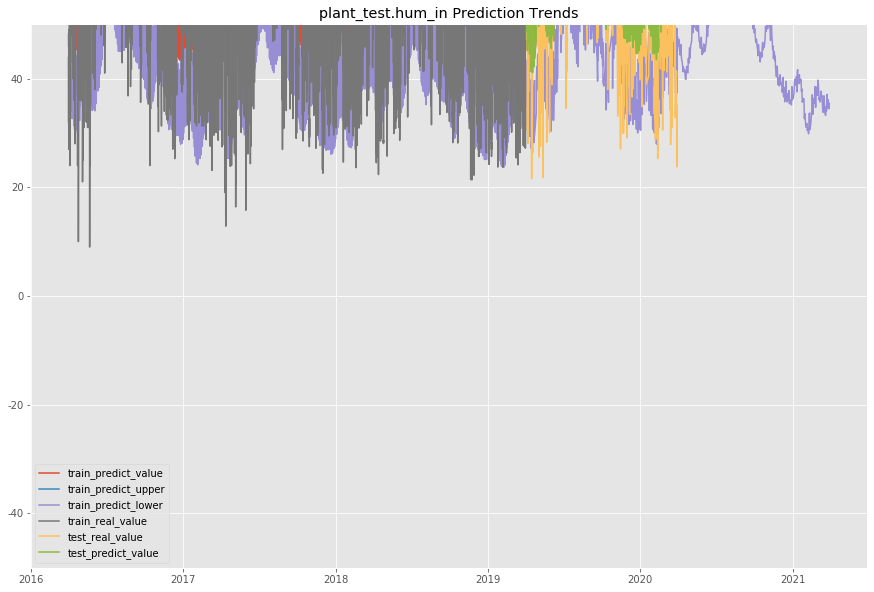

Prophet Predict RMSE :  12.337897129398227


In [56]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_hum13, forecast48_hum13 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,3,
                                                                                                               'plant1_train.hum_in_loc3',
                                                                                                               'plant_test.hum_in')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


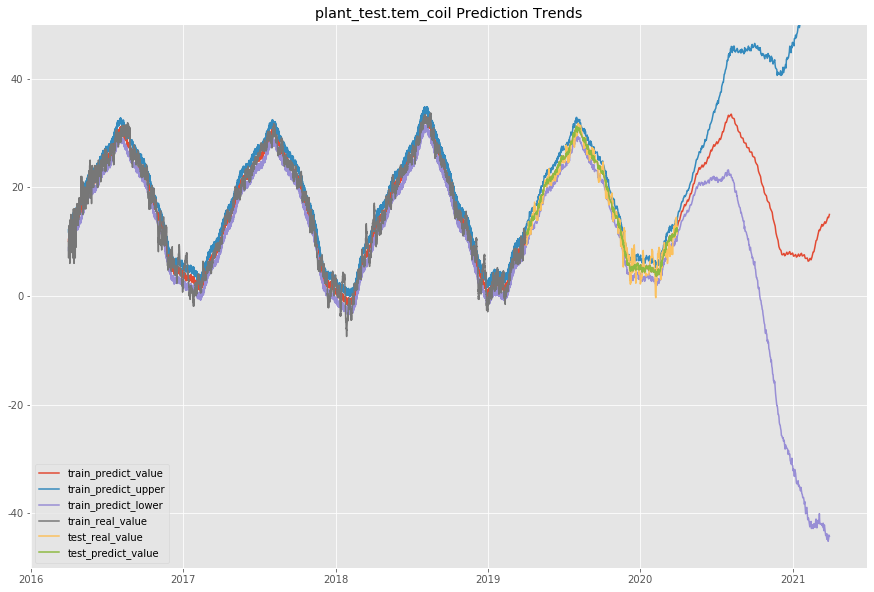

Prophet Predict RMSE :  1.5079443630738945


In [57]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_coiltem13, forecast48_coiltem13 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,3,
                                                                                                               'plant1_train.tem_coil_loc3',
                                                                                                               'plant_test.tem_coil')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


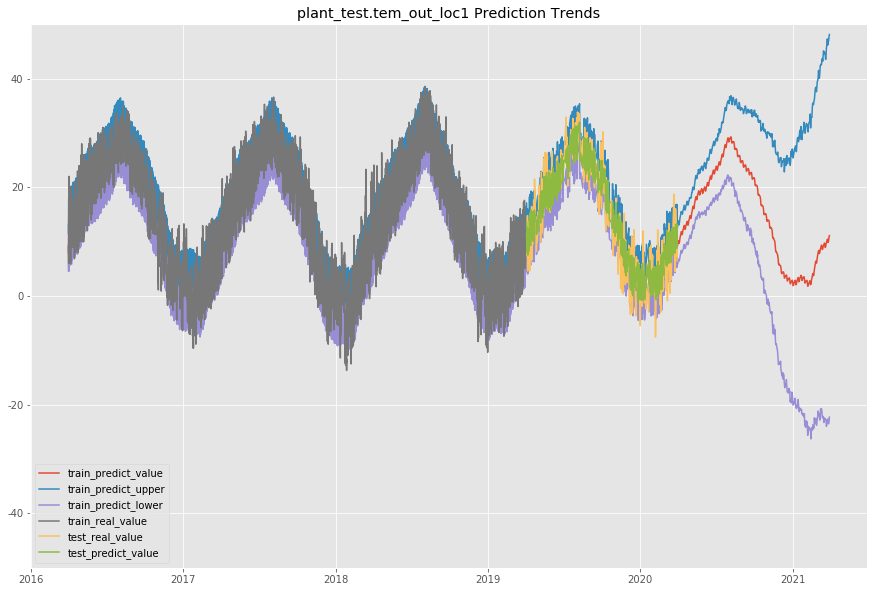

Prophet Predict RMSE :  2.948678954265987


In [58]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_temout13, forecast48_temout13 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,3,
                                                                                                               'plant1_train.tem_out_loc1',
                                                                                                               'plant_test.tem_out_loc1')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


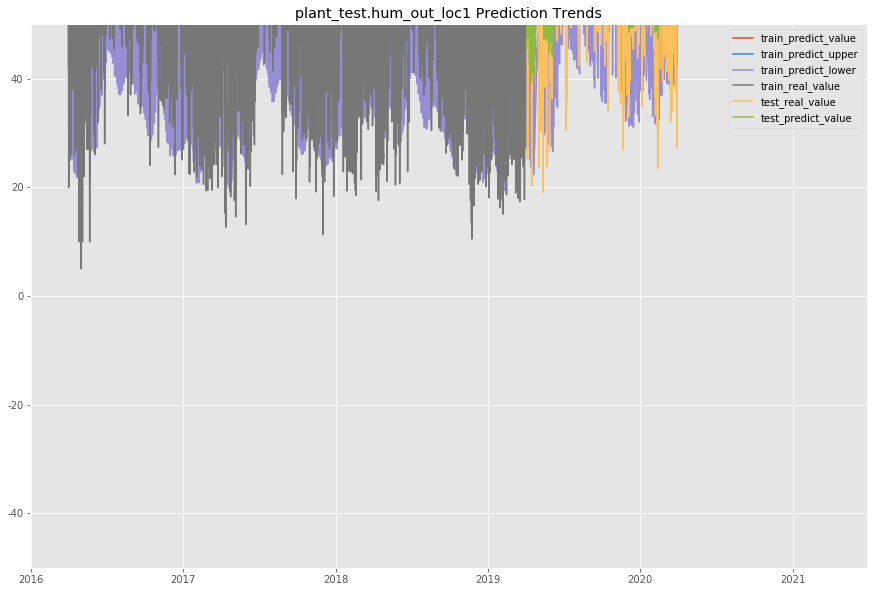

Prophet Predict RMSE :  15.492364164536498


In [59]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_humout13, forecast48_humout13 = each_variable_prophet_predict(\
                                                                                                               pt1,
                                                                                                               pt_test,
                                                                                                               1,3,
                                                                                                               'plant1_train.hum_out_loc1',
                                                                                                               'plant_test.hum_out_loc1')

#### plant 2 / location 1

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


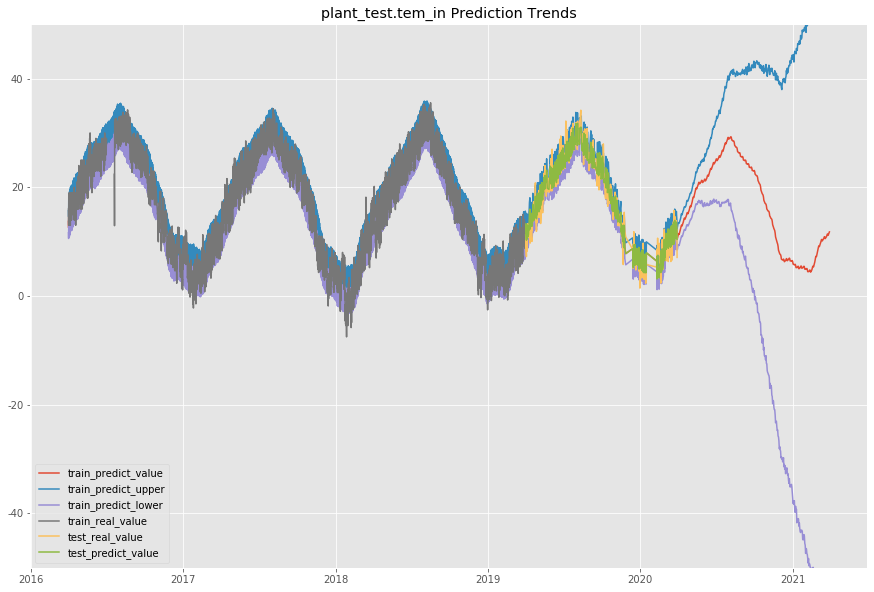

Prophet Predict RMSE :  1.6088351004889503


In [60]:
# plant1, location1, in_tem
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_tem21, forecast48_tem21 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,1,
                                                                                                               'plant2_train.tem_in_loc1',
                                                                                                               'plant_test.tem_in')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


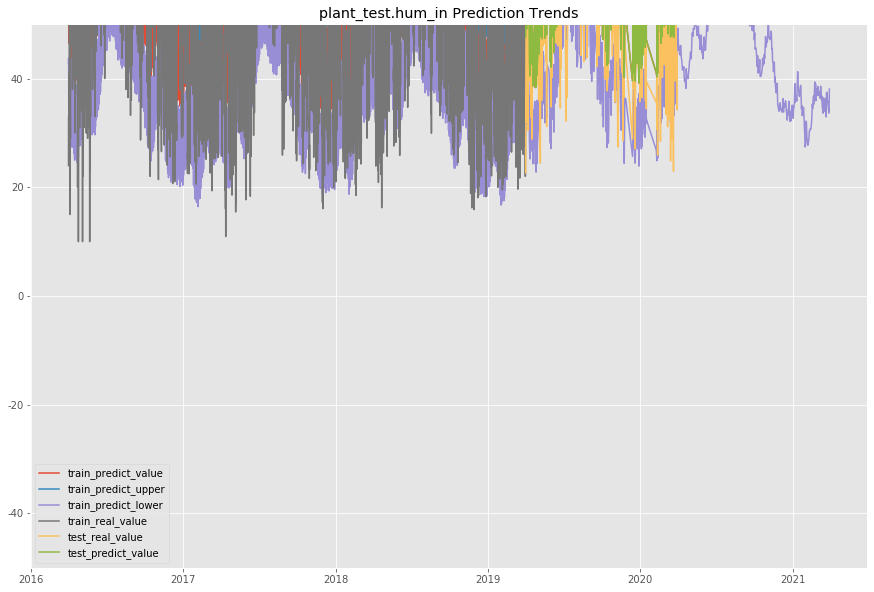

Prophet Predict RMSE :  12.443784116147715


In [61]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_hum21, forecast48_hum21 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,1,
                                                                                                               'plant2_train.hum_in_loc1',
                                                                                                               'plant_test.hum_in')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


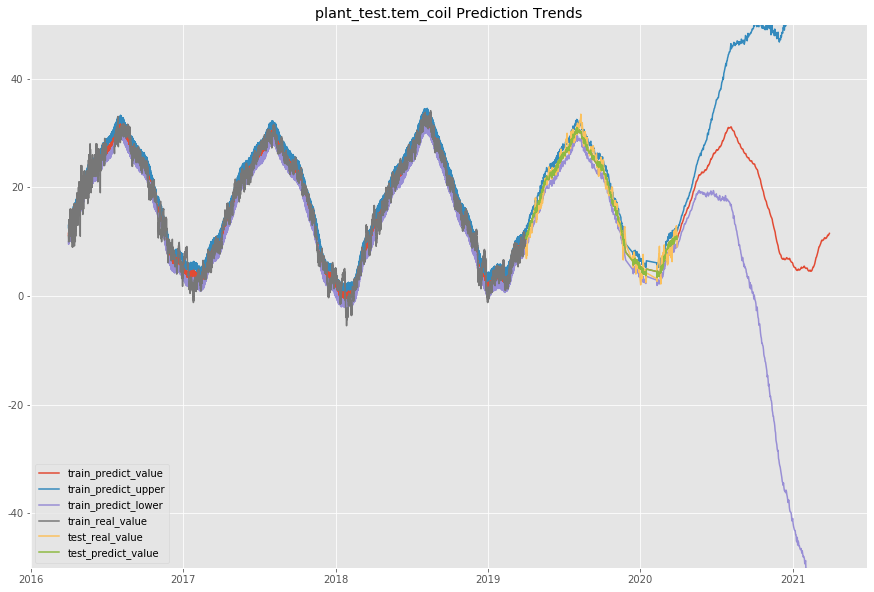

Prophet Predict RMSE :  1.263556266480926


In [62]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_coiltem21, forecast48_coiltem21 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,1,
                                                                                                               'plant2_train.tem_coil_loc1',
                                                                                                               'plant_test.tem_coil')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


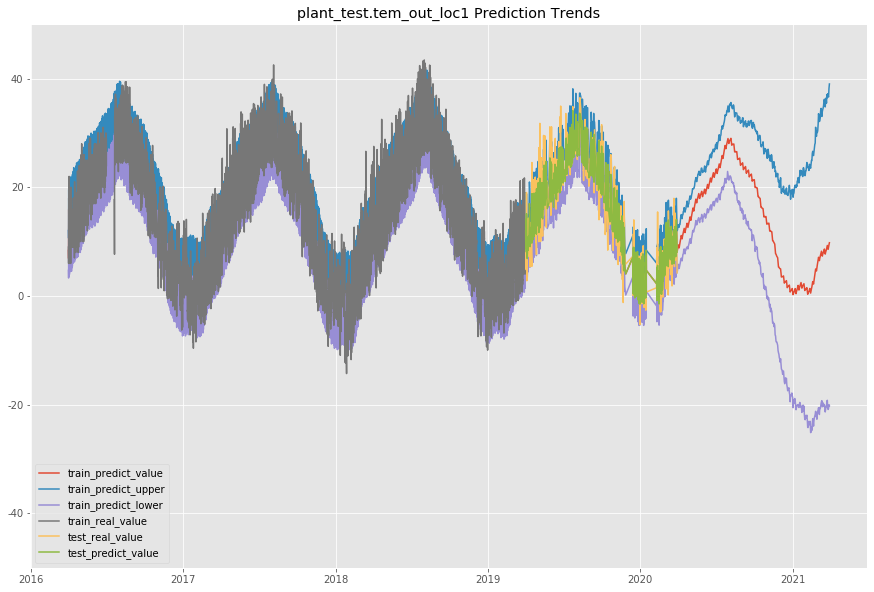

Prophet Predict RMSE :  3.1592306698719175


In [63]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_temout21, forecast48_temout21 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,1,
                                                                                                               'plant2_train.tem_out_loc1',
                                                                                                               'plant_test.tem_out_loc1')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


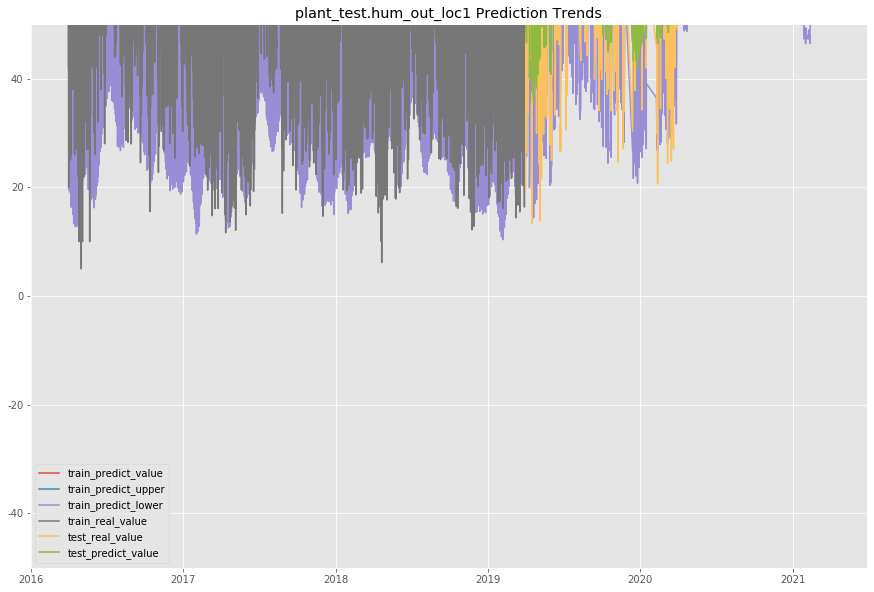

Prophet Predict RMSE :  17.312905663780562


In [64]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_humout21, forecast48_humout21 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,1,
                                                                                                               'plant2_train.hum_out_loc1',
                                                                                                               'plant_test.hum_out_loc1')

#### plant 2 / location 2

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


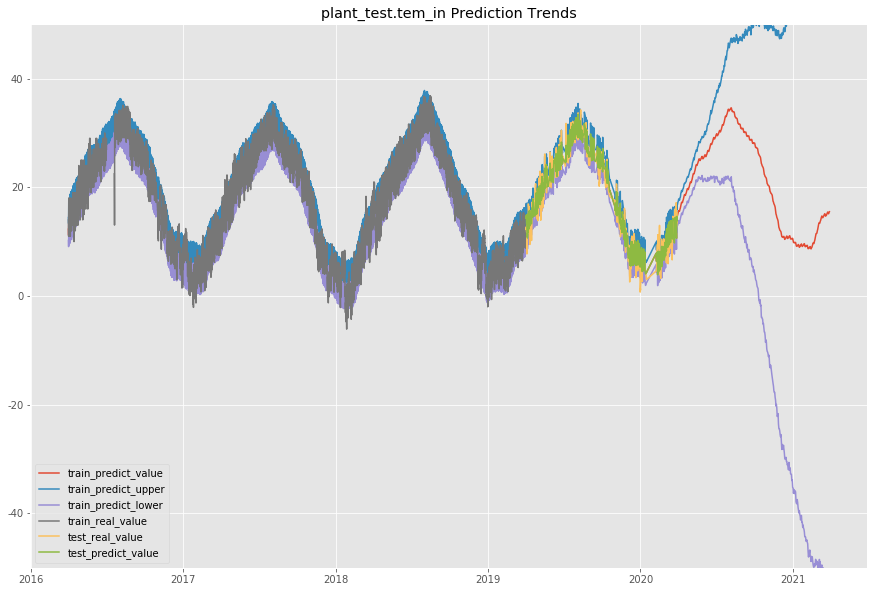

Prophet Predict RMSE :  1.6601138591756501


In [65]:
# plant1, location1, in_tem
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_tem22, forecast48_tem22 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,2,
                                                                                                               'plant2_train.tem_in_loc2',
                                                                                                               'plant_test.tem_in')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


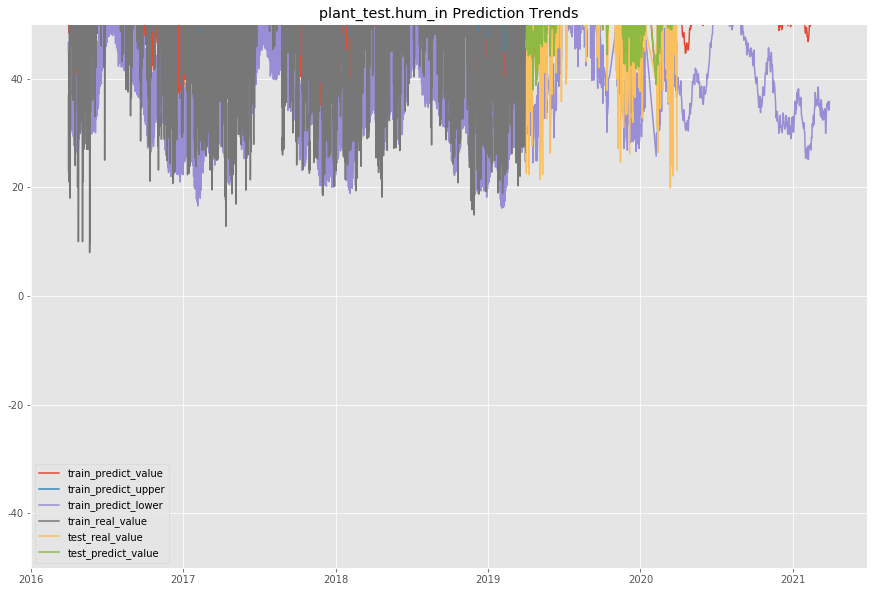

Prophet Predict RMSE :  12.981310071905826


In [66]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_hum22, forecast48_hum22 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,2,
                                                                                                               'plant2_train.hum_in_loc2',
                                                                                                               'plant_test.hum_in')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


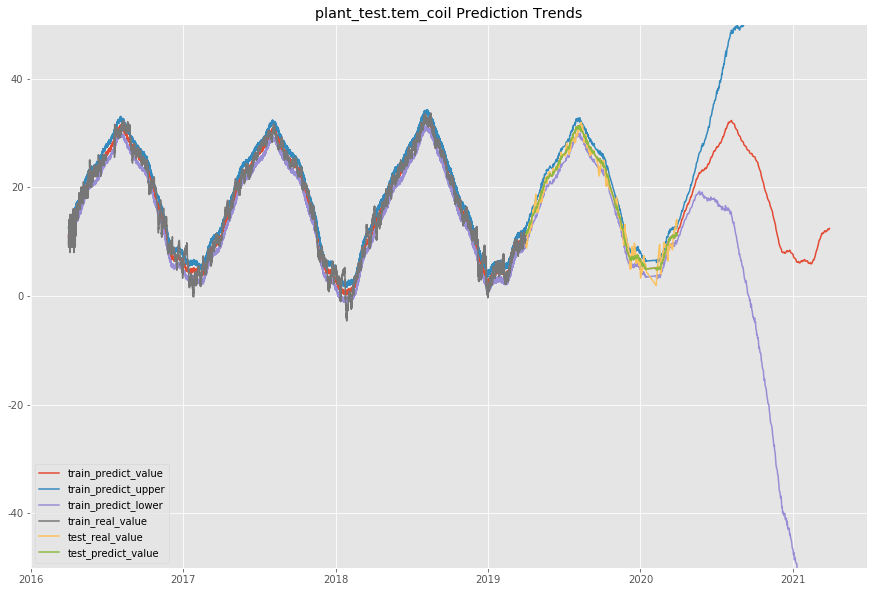

Prophet Predict RMSE :  1.1924679958850248


In [67]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_coiltem22, forecast48_coiltem22 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,2,
                                                                                                               'plant2_train.tem_coil_loc2',
                                                                                                               'plant_test.tem_coil')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


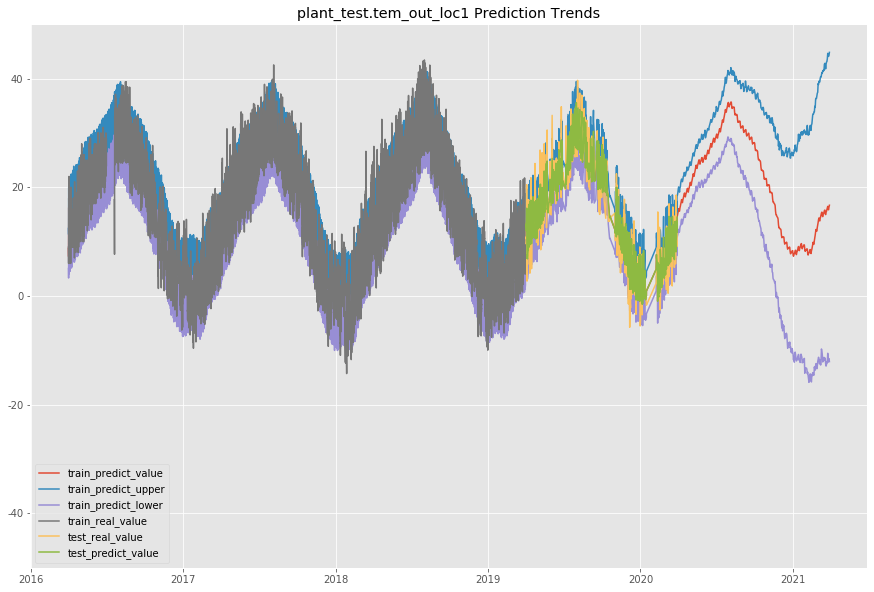

Prophet Predict RMSE :  3.2037857126140685


In [68]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_temout22, forecast48_temout22 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,2,
                                                                                                               'plant2_train.tem_out_loc1',
                                                                                                               'plant_test.tem_out_loc1')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


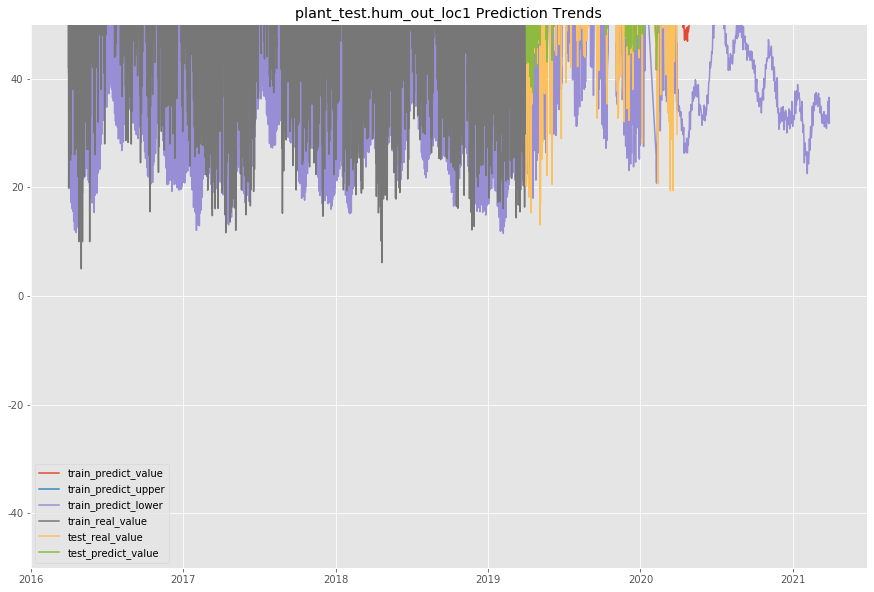

Prophet Predict RMSE :  17.127053042370072


In [69]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_humout22, forecast48_humout22 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,2,
                                                                                                               'plant2_train.hum_out_loc1',
                                                                                                               'plant_test.hum_out_loc1')

#### plant 2 / location 3

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


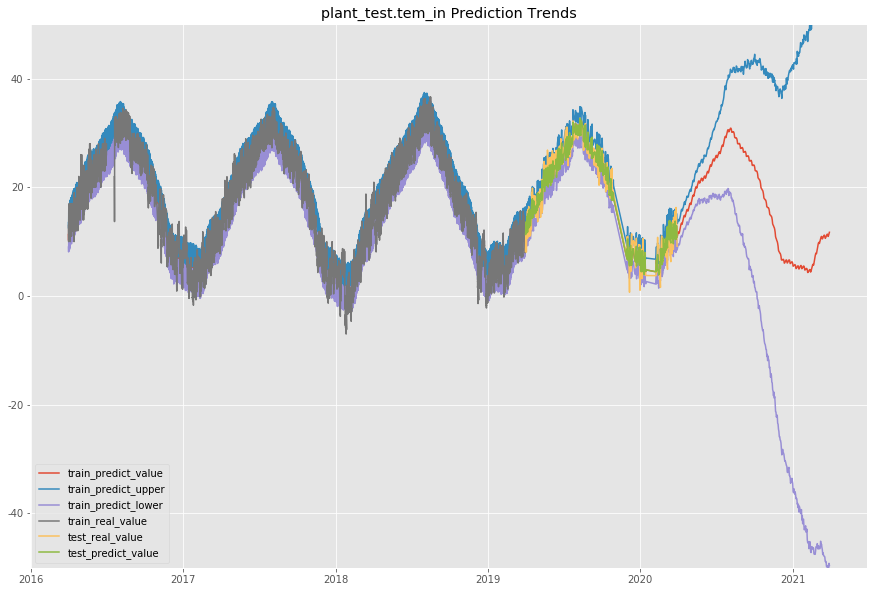

Prophet Predict RMSE :  1.7694395346188352


In [70]:
# plant1, location1, in_tem
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_tem23, forecast48_tem23 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,3,
                                                                                                               'plant2_train.tem_in_loc3',
                                                                                                               'plant_test.tem_in')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


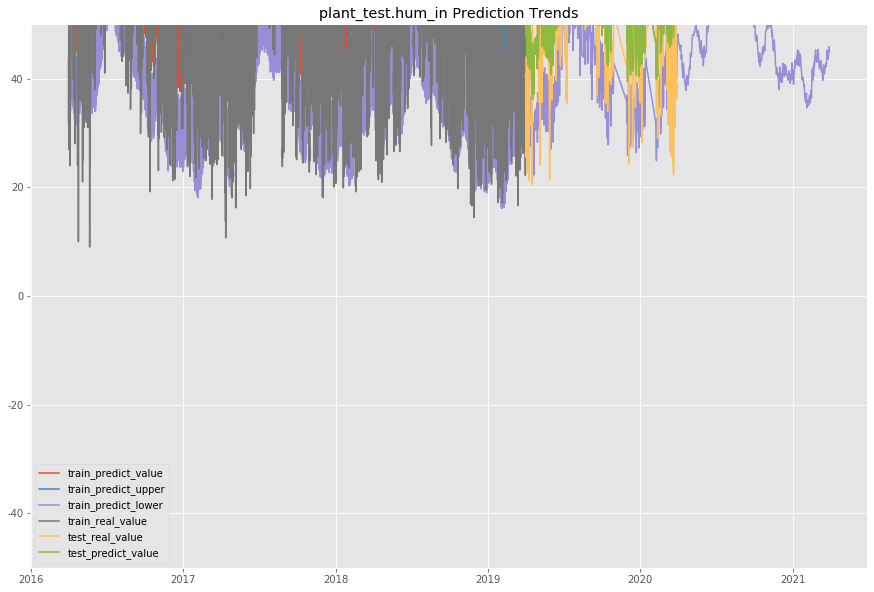

Prophet Predict RMSE :  12.164551220028956


In [71]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_hum23, forecast48_hum23 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,3,
                                                                                                               'plant2_train.hum_in_loc3',
                                                                                                               'plant_test.hum_in')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


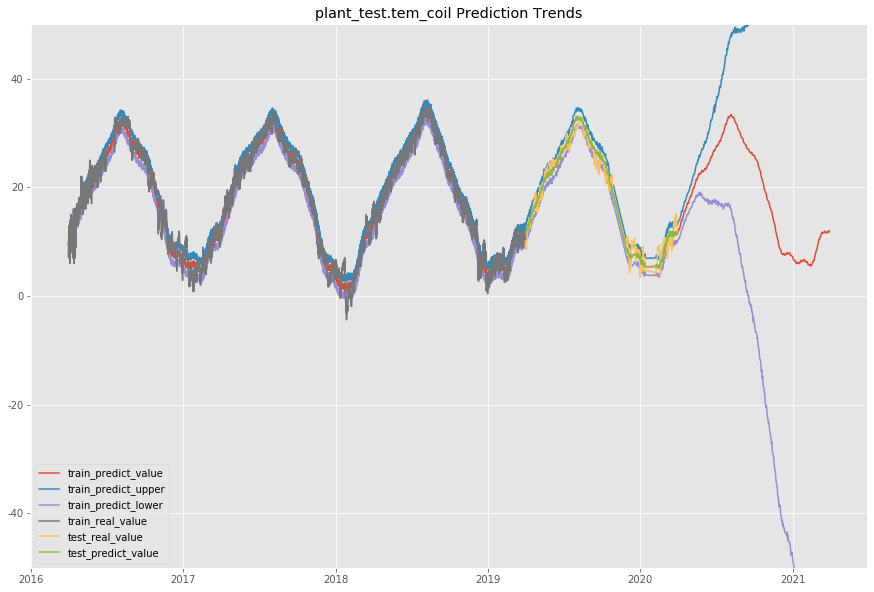

Prophet Predict RMSE :  1.417000437150645


In [72]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_coiltem23, forecast48_coiltem23 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,3,
                                                                                                               'plant2_train.tem_coil_loc3',
                                                                                                               'plant_test.tem_coil')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


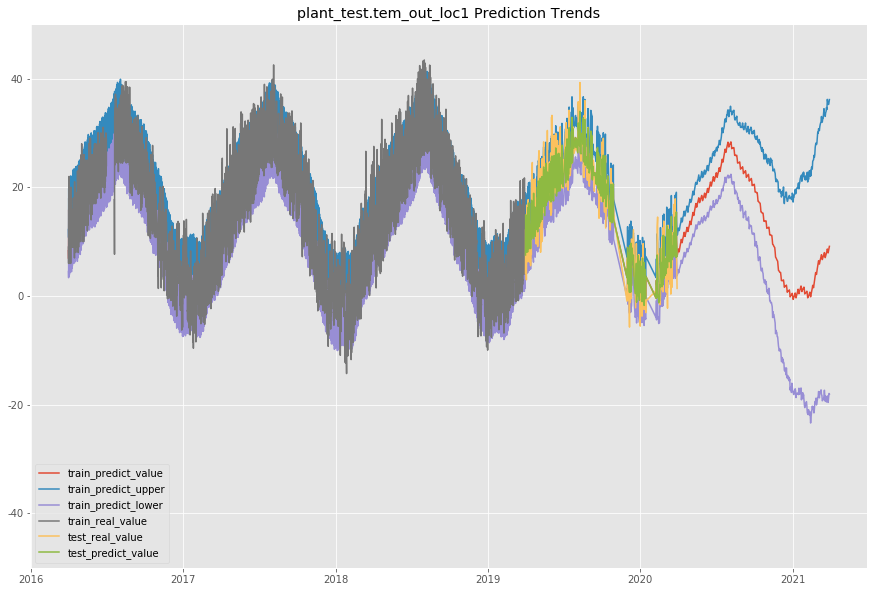

Prophet Predict RMSE :  3.1294720974383994


In [73]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_temout23, forecast48_temout23 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,3,
                                                                                                               'plant2_train.tem_out_loc1',
                                                                                                               'plant_test.tem_out_loc1')

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


fitting success


/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


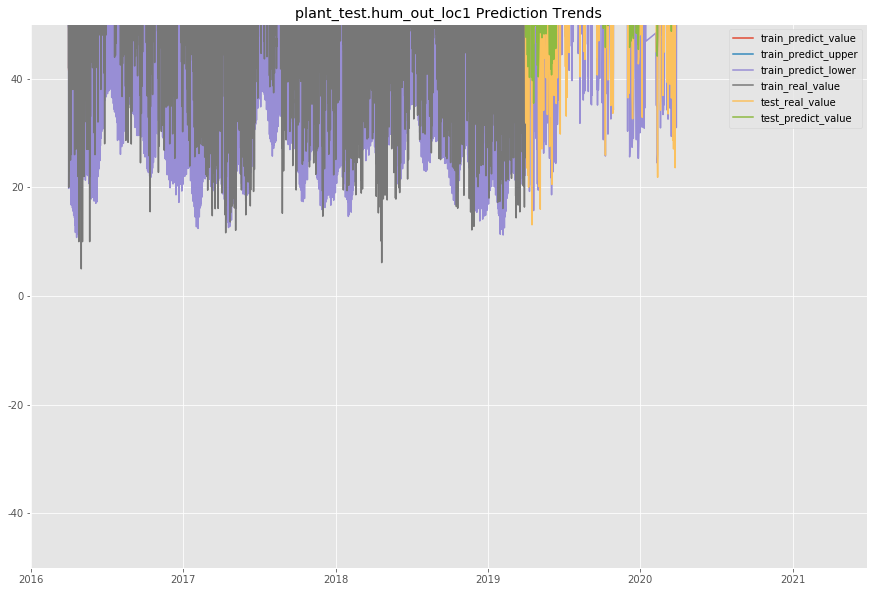

Prophet Predict RMSE :  17.49604351036574


In [74]:
# plant1, location1, in_hum
plant1_loc1_in_tem_predict, plant1_loc1_in_tem_base,rmse, forecast24_humout23, forecast48_humout23 = each_variable_prophet_predict(\
                                                                                                               pt2,
                                                                                                               pt_test,
                                                                                                               2,3,
                                                                                                               'plant2_train.hum_out_loc1',
                                                                                                               'plant_test.hum_out_loc1')

# 데이터 병합

In [75]:
forecast24_tem11['plant'] = 1
forecast24_tem11['loc'] = 1

forecast24_tem12['plant'] = 1
forecast24_tem12['loc'] = 2

forecast24_tem13['plant'] = 1
forecast24_tem13['loc'] = 3


forecast24_tem21['plant'] = 2
forecast24_tem21['loc'] = 1

forecast24_tem22['plant'] = 2
forecast24_tem22['loc'] = 2

forecast24_tem23['plant'] = 2
forecast24_tem23['loc'] = 3

#########
forecast24_hum11['plant'] = 1
forecast24_hum11['loc'] = 1

forecast24_hum12['plant'] = 1
forecast24_hum12['loc'] = 2

forecast24_hum13['plant'] = 1
forecast24_hum13['loc'] = 3

forecast24_hum21['plant'] = 2
forecast24_hum21['loc'] = 1

forecast24_hum22['plant'] = 2
forecast24_hum22['loc'] = 2

forecast24_hum23['plant'] = 2
forecast24_hum23['loc'] = 3

#########

forecast24_coiltem11['plant'] = 1
forecast24_coiltem11['loc'] = 1

forecast24_coiltem12['plant'] = 1
forecast24_coiltem12['loc'] = 2

forecast24_coiltem13['plant'] = 1
forecast24_coiltem13['loc'] = 3

forecast24_coiltem21['plant'] = 2
forecast24_coiltem21['loc'] = 1

forecast24_coiltem22['plant'] = 2
forecast24_coiltem22['loc'] = 2

forecast24_coiltem23['plant'] = 2
forecast24_coiltem23['loc'] = 3

#########

forecast24_temout11['plant'] = 1
forecast24_temout11['loc'] = 1

forecast24_temout12['plant'] = 1
forecast24_temout12['loc'] = 2

forecast24_temout13['plant'] = 1
forecast24_temout13['loc'] = 3

forecast24_temout21['plant'] = 2
forecast24_temout21['loc'] = 1

forecast24_temout22['plant'] = 2
forecast24_temout22['loc'] = 2

forecast24_temout23['plant'] = 2
forecast24_temout23['loc'] = 3

########

forecast24_humout11['plant'] = 1
forecast24_humout11['loc'] = 1

forecast24_humout12['plant'] = 1
forecast24_humout12['loc'] = 2

forecast24_humout13['plant'] = 1
forecast24_humout13['loc'] = 3

forecast24_humout21['plant'] = 2
forecast24_humout21['loc'] = 1

forecast24_humout22['plant'] = 2
forecast24_humout22['loc'] = 2

forecast24_humout23['plant'] = 2
forecast24_humout23['loc'] = 3


In [77]:
pred24_tem11 = forecast24_tem11[['ds','yhat','plant','loc']]
pred24_tem12 = forecast24_tem12[['ds','yhat','plant','loc']]
pred24_tem13 = forecast24_tem13[['ds','yhat','plant','loc']]

pred24_tem21 = forecast24_tem21[['ds','yhat','plant','loc']]
pred24_tem22 = forecast24_tem22[['ds','yhat','plant','loc']]
pred24_tem23 = forecast24_tem23[['ds','yhat','plant','loc']]

pred24_tem_total = pd.concat([pred24_tem11,pred24_tem12,pred24_tem13,pred24_tem21,pred24_tem22,pred24_tem23],axis=0)
pred24_tem_total.columns = ['ds','pred24_tem','plant','loc']
########
pred24_hum11 = forecast24_hum11[['ds','yhat','plant','loc']]
pred24_hum12 = forecast24_hum12[['ds','yhat','plant','loc']]
pred24_hum13 = forecast24_hum13[['ds','yhat','plant','loc']]

pred24_hum21 = forecast24_hum21[['ds','yhat','plant','loc']]
pred24_hum22 = forecast24_hum22[['ds','yhat','plant','loc']]
pred24_hum23 = forecast24_hum23[['ds','yhat','plant','loc']]

pred24_hum_total = pd.concat([pred24_hum11,pred24_hum12,pred24_hum13,pred24_hum21,pred24_hum22,pred24_hum23],axis=0)
pred24_hum_total.columns = ['ds','pred24_hum','plant','loc']

########
pred24_coiltem11 = forecast24_coiltem11[['ds','yhat','plant','loc']]
pred24_coiltem12 = forecast24_coiltem12[['ds','yhat','plant','loc']]
pred24_coiltem13 = forecast24_coiltem13[['ds','yhat','plant','loc']]

pred24_coiltem21 = forecast24_coiltem21[['ds','yhat','plant','loc']]
pred24_coiltem22 = forecast24_coiltem22[['ds','yhat','plant','loc']]
pred24_coiltem23 = forecast24_coiltem23[['ds','yhat','plant','loc']]

pred24_coiltem_total = pd.concat([pred24_coiltem11,pred24_coiltem12,pred24_coiltem13,pred24_coiltem21,pred24_coiltem22,pred24_coiltem23],axis=0)
pred24_coiltem_total.columns = ['ds','pred24_coiltem','plant','loc']

########
pred24_temout11 = forecast24_temout11[['ds','yhat','plant','loc']]
pred24_temout12 = forecast24_temout12[['ds','yhat','plant','loc']]
pred24_temout13 = forecast24_temout13[['ds','yhat','plant','loc']]

pred24_temout21 = forecast24_temout21[['ds','yhat','plant','loc']]
pred24_temout22 = forecast24_temout22[['ds','yhat','plant','loc']]
pred24_temout23 = forecast24_temout23[['ds','yhat','plant','loc']]

pred24_temout_total = pd.concat([pred24_temout11,pred24_temout12,pred24_temout13,pred24_temout21,pred24_temout22,pred24_temout23],axis=0)
pred24_temout_total.columns = ['ds','pred24_temout','plant','loc']

########
pred24_humout11 = forecast24_humout11[['ds','yhat','plant','loc']]
pred24_humout12 = forecast24_humout12[['ds','yhat','plant','loc']]
pred24_humout13 = forecast24_humout13[['ds','yhat','plant','loc']]

pred24_humout21 = forecast24_humout21[['ds','yhat','plant','loc']]
pred24_humout22 = forecast24_humout22[['ds','yhat','plant','loc']]
pred24_humout23 = forecast24_humout23[['ds','yhat','plant','loc']]

pred24_humout_total = pd.concat([pred24_humout11,pred24_humout12,pred24_humout13,pred24_humout21,pred24_humout22,pred24_humout23],axis=0)
pred24_humout_total.columns = ['ds','pred24_humout','plant','loc']

In [81]:
pred24_total0 = pd.merge(pred24_tem_total,pred24_hum_total,left_on = ['ds','plant','loc'], right_on = ['ds','plant','loc'], how = 'left')
pred24_total1 = pd.merge(pred24_total0,pred24_coiltem_total,left_on = ['ds','plant','loc'], right_on = ['ds','plant','loc'], how = 'left')
pred24_total2 = pd.merge(pred24_total1,pred24_temout_total,left_on = ['ds','plant','loc'], right_on = ['ds','plant','loc'], how = 'left')
pred24_total3 = pd.merge(pred24_total2,pred24_humout_total,left_on = ['ds','plant','loc'], right_on = ['ds','plant','loc'], how = 'left')

In [92]:
pred24_total3.to_csv('prophet_predict_24hour.csv',index = False)

#### 48시간 예측 데이터 정리

In [88]:
forecast48_tem11['plant'] = 1
forecast48_tem11['loc'] = 1

forecast48_tem12['plant'] = 1
forecast48_tem12['loc'] = 2

forecast48_tem13['plant'] = 1
forecast48_tem13['loc'] = 3


forecast48_tem21['plant'] = 2
forecast48_tem21['loc'] = 1

forecast48_tem22['plant'] = 2
forecast48_tem22['loc'] = 2

forecast48_tem23['plant'] = 2
forecast48_tem23['loc'] = 3

#########
forecast48_hum11['plant'] = 1
forecast48_hum11['loc'] = 1

forecast48_hum12['plant'] = 1
forecast48_hum12['loc'] = 2

forecast48_hum13['plant'] = 1
forecast48_hum13['loc'] = 3

forecast48_hum21['plant'] = 2
forecast48_hum21['loc'] = 1

forecast48_hum22['plant'] = 2
forecast48_hum22['loc'] = 2

forecast48_hum23['plant'] = 2
forecast48_hum23['loc'] = 3

#########

forecast48_coiltem11['plant'] = 1
forecast48_coiltem11['loc'] = 1

forecast48_coiltem12['plant'] = 1
forecast48_coiltem12['loc'] = 2

forecast48_coiltem13['plant'] = 1
forecast48_coiltem13['loc'] = 3

forecast48_coiltem21['plant'] = 2
forecast48_coiltem21['loc'] = 1

forecast48_coiltem22['plant'] = 2
forecast48_coiltem22['loc'] = 2

forecast48_coiltem23['plant'] = 2
forecast48_coiltem23['loc'] = 3

#########

forecast48_temout11['plant'] = 1
forecast48_temout11['loc'] = 1

forecast48_temout12['plant'] = 1
forecast48_temout12['loc'] = 2

forecast48_temout13['plant'] = 1
forecast48_temout13['loc'] = 3

forecast48_temout21['plant'] = 2
forecast48_temout21['loc'] = 1

forecast48_temout22['plant'] = 2
forecast48_temout22['loc'] = 2

forecast48_temout23['plant'] = 2
forecast48_temout23['loc'] = 3

########

forecast48_humout11['plant'] = 1
forecast48_humout11['loc'] = 1

forecast48_humout12['plant'] = 1
forecast48_humout12['loc'] = 2

forecast48_humout13['plant'] = 1
forecast48_humout13['loc'] = 3

forecast48_humout21['plant'] = 2
forecast48_humout21['loc'] = 1

forecast48_humout22['plant'] = 2
forecast48_humout22['loc'] = 2

forecast48_humout23['plant'] = 2
forecast48_humout23['loc'] = 3


In [89]:
pred48_tem11 = forecast48_tem11[['ds','yhat','plant','loc']]
pred48_tem12 = forecast48_tem12[['ds','yhat','plant','loc']]
pred48_tem13 = forecast48_tem13[['ds','yhat','plant','loc']]

pred48_tem21 = forecast48_tem21[['ds','yhat','plant','loc']]
pred48_tem22 = forecast48_tem22[['ds','yhat','plant','loc']]
pred48_tem23 = forecast48_tem23[['ds','yhat','plant','loc']]

pred48_tem_total = pd.concat([pred48_tem11,pred48_tem12,pred48_tem13,pred48_tem21,pred48_tem22,pred48_tem23],axis=0)
pred48_tem_total.columns = ['ds','pred48_tem','plant','loc']
########
pred48_hum11 = forecast48_hum11[['ds','yhat','plant','loc']]
pred48_hum12 = forecast48_hum12[['ds','yhat','plant','loc']]
pred48_hum13 = forecast48_hum13[['ds','yhat','plant','loc']]

pred48_hum21 = forecast48_hum21[['ds','yhat','plant','loc']]
pred48_hum22 = forecast48_hum22[['ds','yhat','plant','loc']]
pred48_hum23 = forecast48_hum23[['ds','yhat','plant','loc']]

pred48_hum_total = pd.concat([pred48_hum11,pred48_hum12,pred48_hum13,pred48_hum21,pred48_hum22,pred48_hum23],axis=0)
pred48_hum_total.columns = ['ds','pred48_hum','plant','loc']

########
pred48_coiltem11 = forecast48_coiltem11[['ds','yhat','plant','loc']]
pred48_coiltem12 = forecast48_coiltem12[['ds','yhat','plant','loc']]
pred48_coiltem13 = forecast48_coiltem13[['ds','yhat','plant','loc']]

pred48_coiltem21 = forecast48_coiltem21[['ds','yhat','plant','loc']]
pred48_coiltem22 = forecast48_coiltem22[['ds','yhat','plant','loc']]
pred48_coiltem23 = forecast48_coiltem23[['ds','yhat','plant','loc']]

pred48_coiltem_total = pd.concat([pred48_coiltem11,pred48_coiltem12,pred48_coiltem13,pred48_coiltem21,pred48_coiltem22,pred48_coiltem23],axis=0)
pred48_coiltem_total.columns = ['ds','pred48_coiltem','plant','loc']

########
pred48_temout11 = forecast48_temout11[['ds','yhat','plant','loc']]
pred48_temout12 = forecast48_temout12[['ds','yhat','plant','loc']]
pred48_temout13 = forecast48_temout13[['ds','yhat','plant','loc']]

pred48_temout21 = forecast48_temout21[['ds','yhat','plant','loc']]
pred48_temout22 = forecast48_temout22[['ds','yhat','plant','loc']]
pred48_temout23 = forecast48_temout23[['ds','yhat','plant','loc']]

pred48_temout_total = pd.concat([pred48_temout11,pred48_temout12,pred48_temout13,pred48_temout21,pred48_temout22,pred48_temout23],axis=0)
pred48_temout_total.columns = ['ds','pred48_temout','plant','loc']

########
pred48_humout11 = forecast48_humout11[['ds','yhat','plant','loc']]
pred48_humout12 = forecast48_humout12[['ds','yhat','plant','loc']]
pred48_humout13 = forecast48_humout13[['ds','yhat','plant','loc']]

pred48_humout21 = forecast48_humout21[['ds','yhat','plant','loc']]
pred48_humout22 = forecast48_humout22[['ds','yhat','plant','loc']]
pred48_humout23 = forecast48_humout23[['ds','yhat','plant','loc']]

pred48_humout_total = pd.concat([pred48_humout11,pred48_humout12,pred48_humout13,pred48_humout21,pred48_humout22,pred48_humout23],axis=0)
pred48_humout_total.columns = ['ds','pred48_humout','plant','loc']

In [90]:
pred48_total0 = pd.merge(pred48_tem_total,pred48_hum_total,left_on = ['ds','plant','loc'], right_on = ['ds','plant','loc'], how = 'left')
pred48_total1 = pd.merge(pred48_total0,pred48_coiltem_total,left_on = ['ds','plant','loc'], right_on = ['ds','plant','loc'], how = 'left')
pred48_total2 = pd.merge(pred48_total1,pred48_temout_total,left_on = ['ds','plant','loc'], right_on = ['ds','plant','loc'], how = 'left')
pred48_total3 = pd.merge(pred48_total2,pred48_humout_total,left_on = ['ds','plant','loc'], right_on = ['ds','plant','loc'], how = 'left')

In [93]:
pred48_total3.to_csv('prophet_predict_48hour.csv',index = False)

# ***base model 학습시키기 위한 데이터셋 구축(병합)***
    - 현재시간으로 현재 결로를 예측하는 모델

In [97]:
pt1_column = pt1.columns

In [99]:
pt1_loc1_ls = []
pt1_loc2_ls = []
pt1_loc3_ls = []

for i in pt1_column:
    
    if 'loc1' in i:
        pt1_loc1_ls.append(i)
    elif 'loc2' in i:
        pt1_loc2_ls.append(i)
    elif 'loc3' in i:
        pt1_loc3_ls.append(i)

In [104]:
pt1_loc2_ls = pt1_loc2_ls + ['plant1_train.tem_out_loc1','plant1_train.hum_out_loc1']
pt1_loc3_ls = pt1_loc3_ls + ['plant1_train.tem_out_loc1','plant1_train.hum_out_loc1']

In [107]:
pt1_loc1_df = pt1[pt1_loc1_ls]
pt1_loc2_df = pt1[pt1_loc2_ls]
pt1_loc3_df = pt1[pt1_loc3_ls]

In [110]:
pt1_loc1_df.columns = ['inner_tem','inner_hum','inner_coil_tem','outer_tem','outer_hum','cond']
pt1_loc2_df.columns = ['inner_tem','inner_hum','inner_coil_tem','cond','outer_tem','outer_hum']
pt1_loc3_df.columns = ['inner_tem','inner_hum','inner_coil_tem','cond','outer_tem','outer_hum']

pt1_loc1_df = pt1_loc1_df[['inner_tem','inner_hum','inner_coil_tem','cond','outer_tem','outer_hum']]

In [115]:
pt1_loc1_df['plant'] = 1
pt1_loc1_df['loc'] = 1

pt1_loc2_df['plant'] = 1
pt1_loc2_df['loc'] = 2

pt1_loc3_df['plant'] = 1
pt1_loc3_df['loc'] = 3

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [118]:
pt1_fin = pd.concat([pt1_loc1_df,pt1_loc2_df,pt1_loc3_df],axis = 0)

In [121]:
pt2_column = pt2.columns
pt2_loc1_ls = []
pt2_loc2_ls = []
pt2_loc3_ls = []

for i in pt2_column:
    
    if 'loc1' in i:
        pt2_loc1_ls.append(i)
    elif 'loc2' in i:
        pt2_loc2_ls.append(i)
    elif 'loc3' in i:
        pt2_loc3_ls.append(i)
        
pt2_loc2_ls = pt2_loc2_ls + ['plant2_train.tem_out_loc1','plant2_train.hum_out_loc1']
pt2_loc3_ls = pt2_loc3_ls + ['plant2_train.tem_out_loc1','plant2_train.hum_out_loc1']

pt2_loc1_df = pt2[pt2_loc1_ls]
pt2_loc2_df = pt2[pt2_loc2_ls]
pt2_loc3_df = pt2[pt2_loc3_ls]

pt2_loc1_df.columns = ['inner_tem','inner_hum','inner_coil_tem','outer_tem','outer_hum','cond']
pt2_loc2_df.columns = ['inner_tem','inner_hum','inner_coil_tem','cond','outer_tem','outer_hum']
pt2_loc3_df.columns = ['inner_tem','inner_hum','inner_coil_tem','cond','outer_tem','outer_hum']

pt2_loc1_df = pt2_loc1_df[['inner_tem','inner_hum','inner_coil_tem','cond','outer_tem','outer_hum']]

pt2_loc1_df['plant'] = 2
pt2_loc1_df['loc'] = 1

pt2_loc2_df['plant'] = 2
pt2_loc2_df['loc'] = 2

pt2_loc3_df['plant'] = 2
pt2_loc3_df['loc'] = 3

pt2_fin = pd.concat([pt2_loc1_df,pt2_loc2_df,pt2_loc3_df],axis = 0)

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [123]:
pt_fin = pd.concat([pt1_fin,pt2_fin],axis = 0)

In [127]:
pt_fin2 = pt_fin.dropna(axis=0)

pt_fin2.to_csv('to_prophet_predict_dataset.csv',index = False)